<a href="https://colab.research.google.com/github/wizard339/education/blob/main/misis/nlp/text_classification/transfer_learning_nlp_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
import torchtext
import gensim.downloader
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.types import Device
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
from prompt_toolkit import output
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

%matplotlib inline
plt.style.use('ggplot')

## Loading data, EDA, data preprocessing

### Loading data

In [2]:
train_raw_data = pd.read_csv(filepath_or_buffer='https://raw.githubusercontent.com/wizard339/education/main/misis/nlp/text_classification/train.csv', index_col=0)
final_test_raw_data = pd.read_csv(filepath_or_buffer='https://raw.githubusercontent.com/wizard339/education/main/misis/nlp/text_classification/test.csv')

print(f'Shape of train: {train_raw_data.shape}')
print(f'Shape of test: {final_test_raw_data.shape}')

Shape of train: (41159, 2)
Shape of test: (3798, 2)


### Working with missing data

Let's look at the data:


In [3]:
train_raw_data.head()

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
train_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41159 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       41158 non-null  object
 1   Sentiment  41155 non-null  object
dtypes: object(2)
memory usage: 964.7+ KB


We can see that there are rows with missing data. Let's look at them:

In [5]:
train_raw_data[train_raw_data['Sentiment'].isnull() == True]

,Text,Sentiment
33122,@PrivyCouncilCA #SocialDistancing isnÂt enoug...,NaN
NaN,Neutral,NaN
39204,@TanDhesi @foreignoffice @Afzal4Gorton @Expres...,NaN
Neutral,NaN,NaN


Let's drop these rows from our DataFrame because they don't carry much value and let's look at the data again:

In [6]:
train_raw_data = train_raw_data.dropna().reset_index(drop=True)
print(f'New shape of train: {train_raw_data.shape}')

New shape of train: (41155, 2)


In [7]:
train_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41155 entries, 0 to 41154
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       41155 non-null  object
 1   Sentiment  41155 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


Let's look at the lines of texts:

(array([ 530., 3268., 4924., 6560., 6257., 7495., 8516., 3053.,  529.,
          23.]),
 array([ 1. ,  7.3, 13.6, 19.9, 26.2, 32.5, 38.8, 45.1, 51.4, 57.7, 64. ]),
 <BarContainer object of 10 artists>)

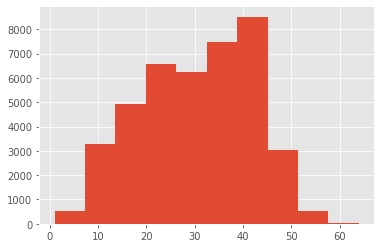

In [8]:
plt.hist([len(text.split()) for text in train_raw_data['Text']])

(array([ 24., 231., 356., 477., 543., 623., 701., 629., 199.,  15.]),
 array([ 2.,  8., 14., 20., 26., 32., 38., 44., 50., 56., 62.]),
 <BarContainer object of 10 artists>)

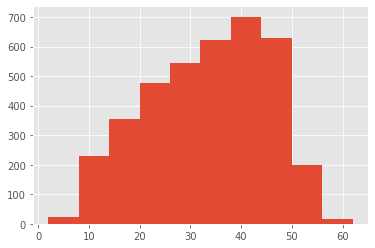

In [9]:
plt.hist([len(text.split()) for text in final_test_raw_data['Text']])

There are no sequences that are too long and the distributions in the training and test samples are similar. It is good.

### Label encoding of target column

In [10]:
train_raw_data['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [11]:
le = LabelEncoder()
le.fit(train_raw_data['Sentiment'])
train_raw_data['Sentiment'] = le.transform(train_raw_data['Sentiment'])
train_raw_data.head(5)

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,3
1,advice Talk to your neighbours family to excha...,4
2,Coronavirus Australia: Woolworths to give elde...,4
3,My food stock is not the only one which is emp...,4
4,"Me, ready to go at supermarket during the #COV...",0


### Сleaning text from useless data

Let's look at the text more closely:

In [12]:
train_raw_data['Text'].sample(10, random_state=42).values

array(['So panic buying of soaps and toilet roll was bad enough, now the idiots are stockpiling alcohol ? whats wrong with people #CoronaVirus #StopPanicBuying #Covid_19',
       'I would place a large amount of money this is the guy buying 90 of the toilet paper',
       '"Saudi Arabia is bracing for an economic downturn as oil prices plummet due to the #coronavirus pandemic" https://t.co/PQ3eRX9euZ',
       '#Foodsecurity #coronavirus #covid19 \r\r\n1.Smooth flow of global trade will help secure food supply\r\r\n2.Monitoring food prices and markets\r\r\n3.Sharing relevant information transparently\r\r\n4.Supporting the vulnerable countries and populationsÂ\x85https://t.co/tTPmInVVgS https://t.co/Ums3Eueu6J',
       'I d like to know who is stockpiling eggs cheese and ice cream and why I m used to going without as our local Lidl has been running out of all kinds of stuff for years way before Drives me potty Going to the supermarket is like entering a lottery',
       'Whenever you tou

In [13]:
def text_cleaner(text: str) -> str:
    '''will clean from unicode, url, hashtags, numbers,
    nicknames, lower'''
    # text = re.sub(r'[.,#!$%\^&\*;:{}=\-_`~()]',r'',text) # punct.
    
    # text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]', r'', text)# unicode

    text = re.sub(r'(\\[a-z])', r'', text)
    
    text = re.sub(r'http\S+', r'', text)# url
    
    text = re.sub('@[A-Za-z0-9_-]+', r'', text)# nickname
    
    text = re.sub(r'#([^\s]+)', r'\1', text)# hashtag symbol
    
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:',
                  '', text) # emoji
    
    text = ''.join([i for i in text if not i.isdigit()])# int.
    
    text = text.lower()
    return text

In [14]:
train_raw_data['Text'] = train_raw_data['Text'].apply(text_cleaner)
final_test_raw_data['Text'] = final_test_raw_data['Text'].apply(text_cleaner)
train_raw_data['Text'].sample(10, random_state=42).values

array(['so panic buying of soaps and toilet roll was bad enough, now the idiots are stockpiling alcohol ? whats wrong with people coronavirus stoppanicbuying covid_',
       'i would place a large amount of money this is the guy buying  of the toilet paper',
       '"saudi arabia is bracing for an economic downturn as oil prices plummet due to the coronavirus pandemic" ',
       'foodsecurity coronavirus covid \r\r\n.smooth flow of global trade will help secure food supply\r\r\n.monitoring food prices and markets\r\r\n.sharing relevant information transparently\r\r\n.supporting the vulnerable countries and populations ',
       'i d like to know who is stockpiling eggs cheese and ice cream and why i m used to going without as our local lidl has been running out of all kinds of stuff for years way before drives me potty going to the supermarket is like entering a lottery',
       'whenever you touch any object or surface outside your abode washyourhands with soapandwater\r\r\n\r\r\nstay

### Tokenization

In [15]:
tokenizer = get_tokenizer('basic_english')

def build_vocabulary(datasets):
  for dataset in datasets:
    for text in dataset['Text']:
      yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([train_raw_data, final_test_raw_data]), specials=['<UNK>'])
vocab.set_default_index(vocab['<UNK>'])

In [16]:
print(f'Vocabulary length: {vocab.__len__()}')

Vocabulary length: 50653


### Splitting of training data

We need to split our train_raw_data by train, validation and test samples in the proportions of 60:20:20.

However, our data contain texts for 5 classes, so it is necessary to keep stratification after their splitting.

In [17]:
# first, we will split data by two samples: train and test in the proportion of 60:40
train_data, test_data = train_test_split(train_raw_data, test_size=0.2, stratify=train_raw_data['Sentiment'], random_state=42)
# then, we will split test data by two samples: validation and test in the proportion of 50:50 
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['Sentiment'], random_state=42)

Check the stratification:

In [18]:
train_raw_data['Sentiment'].value_counts(normalize=True)

4    0.277536
2    0.240967
3    0.187365
1    0.160952
0    0.133179
Name: Sentiment, dtype: float64

In [19]:
train_data['Sentiment'].value_counts(normalize=True)

4    0.277518
2    0.240979
3    0.187371
1    0.160946
0    0.133186
Name: Sentiment, dtype: float64

In [20]:
val_data['Sentiment'].value_counts(normalize=True)

4    0.277521
2    0.240826
3    0.187363
1    0.161118
0    0.133171
Name: Sentiment, dtype: float64

In [21]:
test_data['Sentiment'].value_counts(normalize=True)

4    0.277697
2    0.241011
3    0.187318
1    0.160836
0    0.133139
Name: Sentiment, dtype: float64

In [22]:
print(f'Shape of the train_data: {train_data.shape}')
print(f'Shape of the val_data: {val_data.shape}')
print(f'Shape of the test_data: {test_data.shape}')
print(f'Shape of the finel_test_raw_data: {final_test_raw_data.shape}')

Shape of the train_data: (32924, 2)
Shape of the val_data: (4115, 2)
Shape of the test_data: (4116, 2)
Shape of the finel_test_raw_data: (3798, 2)


### Creating datasets

In [23]:
train_dataset, val_dataset, test_dataset, final_test_dataset = to_map_style_dataset(train_data.values), \
                                                               to_map_style_dataset(val_data.values), \
                                                               to_map_style_dataset(test_data.values), \
                                                               to_map_style_dataset(final_test_raw_data.values)

MAX_WORDS  = 50
BATCH_SIZE = 1024

def vectorize_batch(batch):
  X, Y = list(zip(*batch))
  X = [vocab(tokenizer(text)) for text in X] # tokenize and map tokens to indexes
  X = [tokens+([0]*(MAX_WORDS - len(tokens))) if len(tokens) < MAX_WORDS else tokens[:MAX_WORDS] for tokens in X]
  return torch.tensor(X, dtype=torch.int32, device='cpu'), torch.tensor(Y, device='cpu')


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
val_loader  = DataLoader(val_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
final_test_loader  = DataLoader(final_test_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch)

## Building LSTM model

In [25]:
EMBED_LEN  = 50
HIDDEN_DIM = 75
N_LAYERS   = 3

target_classes = train_raw_data['Sentiment'].unique()

class LSTMClassifier(nn.Module):
  def __init__(self):
    super(LSTMClassifier, self).__init__()
    self.emb_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
    self.lstm = nn.LSTM(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS, dropout=0.5, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(in_features=HIDDEN_DIM*2, out_features=len(target_classes))
    self.softmax = nn.LogSoftmax(dim=1)
    

  def forward(self, X_batch):
    emb = self.emb_layer(X_batch)
    output, (h, c) = self.lstm(emb)
    output = self.fc(output[:, -1])
    return self.softmax(output)

In [26]:
lstm_classifier = LSTMClassifier()

lstm_classifier

LSTMClassifier(
  (emb_layer): Embedding(50653, 50)
  (lstm): LSTM(50, 75, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=150, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [27]:
for layer in lstm_classifier.children():
  print(f'Layer: {layer}')
  print('Parameters: ')
  for param in layer.parameters():
    print(param.shape)
  print()

Layer: Embedding(50653, 50)
Parameters: 
torch.Size([50653, 50])

Layer: LSTM(50, 75, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
Parameters: 
torch.Size([300, 50])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 50])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 150])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 150])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 150])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 150])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])

Layer: Linear(in_features=150, out_features=5, bias=True)
Parameters: 
torch.Size([5, 150])
torch.Size([5])

Layer: LogSoftmax(dim=1)
Parameters: 



### Save model and plots

In [28]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, path
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch}\n")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, path + 'best_model.pth')
            

def save_model(epochs, model, optimizer, criterion, path):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, path + 'final_model.pth')
    

def save_plots(valid_acc, train_loss, valid_loss, path):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(path + 'accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(path + 'loss.png')


save_best_model = SaveBestModel()

### Training loop and calculation validation loss and accuracy


In [29]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
  with torch.no_grad():
    Y_shuffled, Y_preds, losses = [], [], []
    for X, Y in val_loader:
      preds = model(X)
      loss = loss_fn(preds, Y)
      losses.append(loss.item())

      Y_shuffled.append(Y)
      Y_preds.append(preds.argmax(dim=-1))

    Y_shuffled = torch.cat(Y_shuffled)
    Y_preds = torch.cat(Y_preds)

    valid_loss = torch.tensor(losses).cpu().mean()
    valid_acc = accuracy_score(Y_shuffled.cpu().detach().numpy(), Y_preds.cpu().detach().numpy())

    print(f'Valid Loss: {valid_loss:.3f}')
    print(f'Valid Acc : {valid_acc:.3f}')

    return valid_loss, valid_acc


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, device, epochs=10, path='/checkpoints/'):
  train_losses, val_losses, val_accs = [], [], []
  for i in range(1, epochs+1):
    losses = []
    for X, Y in tqdm(train_loader):
      X.to(device)
      Y.to(device)
      model.to(device)

      Y_preds = model(X)

      loss = loss_fn(Y_preds, Y)
      losses.append(loss.item())

      optimizer.zero_grad()

      loss.backward()
      optimizer.step()

    train_loss = torch.tensor(losses).mean()
    print(f'Train Loss: {train_loss:.3f}')
    valid_loss, valid_acc = CalcValLossAndAccuracy(model, loss_fn, val_loader)

    # save the best model
    save_best_model(valid_loss, i, model, optimizer, loss_fn, path)

    # append losses and accuracy to lists
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)

  # save the trained model weights for a final time
  save_model(i, model, optimizer, loss_fn, path)
  # save the loss and accuracy plots
  save_plots(val_accs, train_losses, val_losses, path)

### Launching the model



In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

100%|██████████| 33/33 [02:14<00:00,  4.08s/it]


Train Loss: 1.546
Valid Loss: 1.507
Valid Acc : 0.300

Best validation loss: 1.5071988105773926

Saving best model for epoch: 1



100%|██████████| 33/33 [02:13<00:00,  4.05s/it]


Train Loss: 1.511
Valid Loss: 1.474
Valid Acc : 0.318

Best validation loss: 1.474320888519287

Saving best model for epoch: 2



100%|██████████| 33/33 [02:12<00:00,  4.00s/it]


Train Loss: 1.435
Valid Loss: 1.355
Valid Acc : 0.375

Best validation loss: 1.3553061485290527

Saving best model for epoch: 3



100%|██████████| 33/33 [02:07<00:00,  3.85s/it]


Train Loss: 1.265
Valid Loss: 1.267
Valid Acc : 0.499

Best validation loss: 1.2668088674545288

Saving best model for epoch: 4



100%|██████████| 33/33 [02:09<00:00,  3.93s/it]


Train Loss: 1.052
Valid Loss: 1.053
Valid Acc : 0.626

Best validation loss: 1.0534570217132568

Saving best model for epoch: 5



100%|██████████| 33/33 [02:09<00:00,  3.93s/it]


Train Loss: 0.856
Valid Loss: 0.858
Valid Acc : 0.679

Best validation loss: 0.857669472694397

Saving best model for epoch: 6



100%|██████████| 33/33 [02:08<00:00,  3.88s/it]


Train Loss: 0.711
Valid Loss: 0.751
Valid Acc : 0.718

Best validation loss: 0.7510145902633667

Saving best model for epoch: 7



100%|██████████| 33/33 [02:06<00:00,  3.82s/it]


Train Loss: 0.594
Valid Loss: 0.692
Valid Acc : 0.734

Best validation loss: 0.692259669303894

Saving best model for epoch: 8



100%|██████████| 33/33 [02:06<00:00,  3.85s/it]


Train Loss: 0.501
Valid Loss: 0.806
Valid Acc : 0.758


100%|██████████| 33/33 [02:06<00:00,  3.83s/it]


Train Loss: 0.435
Valid Loss: 0.726
Valid Acc : 0.771


100%|██████████| 33/33 [02:06<00:00,  3.85s/it]


Train Loss: 0.369
Valid Loss: 0.585
Valid Acc : 0.782

Best validation loss: 0.5850273966789246

Saving best model for epoch: 11



100%|██████████| 33/33 [02:12<00:00,  4.03s/it]


Train Loss: 0.336
Valid Loss: 0.656
Valid Acc : 0.762


100%|██████████| 33/33 [02:08<00:00,  3.89s/it]


Train Loss: 0.307
Valid Loss: 0.758
Valid Acc : 0.784


100%|██████████| 33/33 [02:08<00:00,  3.89s/it]


Train Loss: 0.278
Valid Loss: 0.666
Valid Acc : 0.789


100%|██████████| 33/33 [02:10<00:00,  3.95s/it]


Train Loss: 0.270
Valid Loss: 0.747
Valid Acc : 0.787
Saving final model...


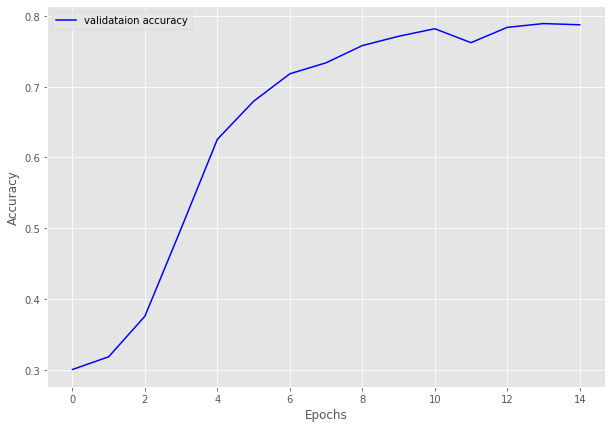

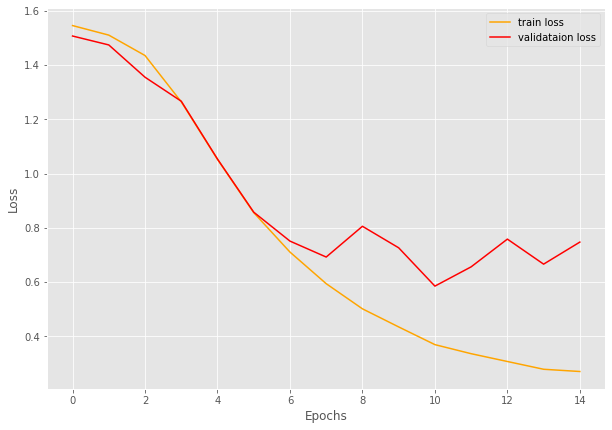

In [31]:
EPOCHS  = 15
LR      = 1e-2
OPT     = Adam(lstm_classifier.parameters(), lr=LR, weight_decay=5e-5)
LOSS_FN = nn.CrossEntropyLoss()
MODEL   = lstm_classifier
PATH    = '/content/checkpoints/'

TrainModel(model=MODEL, loss_fn=LOSS_FN, optimizer=OPT, train_loader=train_loader, val_loader=val_loader, device=device, epochs=EPOCHS, path=PATH)

### Loading the saved model

In [30]:
# checkpoint = torch.load(PATH)
# MODEL.load_state_dict(checkpoint['model_state_dict'])
# OPT.load_state_dict(checkpoint['optimizer_state_dict'])
# EPOCHS = checkpoint['epoch']
# LOSS_FN = checkpoint['loss']

# if we need to continue training
# MODEL.train()
# if we need to inference
# MODEL.eval()

### Test accuracy

In [32]:
def MakePredictions(model, loader, device):
  Y_shuffled, Y_preds= [], []
  for X, Y in loader:
    X.to(device)
    Y.to(device)
    preds = model(X)
    Y_preds.append(preds)
    Y_shuffled.append(Y)
  gc.collect()
  Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

  return Y_shuffled.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1)

Y_actual, Y_preds = MakePredictions(lstm_classifier, test_loader, device)

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

target_classes = le.inverse_transform(target_classes)
print(f'Test Accuracy: {accuracy_score(Y_actual, Y_preds)}')
print('\nClassification report: ')
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print('\nConfusion Matrix: ')
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy: 0.8063654033041788

Classification report: 
                    precision    recall  f1-score   support

           Neutral       0.89      0.71      0.79       548
          Positive       0.87      0.86      0.86       662
Extremely Negative       0.73      0.79      0.76       992
          Negative       0.89      0.83      0.86       771
Extremely Positive       0.76      0.82      0.79      1143

          accuracy                           0.81      4116
         macro avg       0.83      0.80      0.81      4116
      weighted avg       0.81      0.81      0.81      4116


Confusion Matrix: 
[[388   1 153   2   4]
 [  0 572   0   2  88]
 [ 43   4 782  35 128]
 [  2   2  51 639  77]
 [  2  82  79  42 938]]


## Transfer learning